In [1]:
from datasets import load_dataset
from utils import mp3_compress, opus_compress, encodec_compress
from utils import hf_audio_encode
from demucs.separate import Separator
import encodec
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio
import tempfile
import museval

2023-10-24 18:26:17.698072: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-24 18:26:17.718217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-24 18:26:17.718232: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-24 18:26:17.718249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 18:26:17.722623: I tensorflow/core/platform/cpu_feature_g

In [2]:
device = "cuda"
encodec_model_48_6 = encodec.EncodecModel.encodec_model_48khz()
encodec_model_48_6.set_target_bandwidth(6)
encodec_model_48_6.to(device);

In [3]:
def mp3_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = mp3_compress(audio,fs)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

def opus_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = opus_compress(audio,fs)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

def encodec_48_6_compress_musdb(sample):
    audio = torch.tensor(sample['mixture']['array']).to(torch.float32)
    fs = sample['mixture']['sampling_rate']
    audio,bps = encodec_compress(audio,fs,encodec_model_48_6,device)
    sample['mixture'] = hf_audio_encode(audio,fs)
    sample['bps'] = bps
    return sample

In [4]:
audio_compression_methods = [
    mp3_compress_musdb,
    opus_compress_musdb,
    encodec_48_6_compress_musdb
]
musdb = load_dataset("danjacobellis/musdb",split='test')
musdb_mix = musdb.remove_columns(['drums', 'bass', 'other', 'vocals'])
separator = Separator()
fs = musdb[0]['mixture']['sampling_rate']

In [5]:
results = []
for method in audio_compression_methods:
    dataset = musdb_mix.map(method).with_format("torch")
    results.append([])
    for i_sample, sample in enumerate(musdb.with_format("torch")):
        compressed_sample = dataset[i_sample]
        ref = [
            sample['drums']['array'],
            sample['bass']['array'],
            sample['other']['array'],
            sample['vocals']['array']
        ]
        ref = torch.cat([r.permute((1,0)).unsqueeze(0) for r in ref])
        with tempfile.NamedTemporaryFile('w+b', delete=True) as f:
            torchaudio.save(
                f.name,
                compressed_sample['mixture']['array'],
                fs,
                format="wav"
            )
            origin, separated = separator.separate_audio_file(f.name)
        sep = [
            separated['drums'],
            separated['bass'],
            separated['other'],
            separated['vocals']
        ]
        sep = torch.cat([s.permute((1,0)).unsqueeze(0) for s in sep])
        sdr, isr, sir, sar, perm = museval.metrics.bss_eval(
            ref,
            sep,
            window=2 * 44100,
            hop=1.5 * 44100,
            compute_permutation=False,
            filters_len=512,
            framewise_filters=False,
            bsseval_sources_version=False,
        )
        results[-1].append({
            "sdr": sdr,
            "isr": isr,
            "sir": sir,
            "perm": perm
        })

In [6]:
np.save("results.npy",results)

In [100]:
mean_sdr = []
for method in results:
    sdr_with_nans = torch.cat([torch.tensor(sample['sdr']).flatten() for sample in method])
    sdr = []
    for s in sdr_with_nans:
        if not s.isnan():
            sdr.append(s.item())
    mean_sdr.append(torch.tensor(sdr).mean().item())

In [101]:
mean_sdr

[3.4406304359436035, 0.29862770438194275, 2.968838930130005]

In [ ]:
baseline = []
for i_sample, sample in enumerate(musdb.with_format("torch")):
    ref = [
        sample['drums']['array'],
        sample['bass']['array'],
        sample['other']['array'],
        sample['vocals']['array']
    ]
    ref = torch.cat([r.permute((1,0)).unsqueeze(0) for r in ref])
    with tempfile.NamedTemporaryFile('w+b', delete=True) as f:
        torchaudio.save(
            f.name,
            sample['mixture']['array'],
            fs,
            format="wav"
        )
        origin, separated = separator.separate_audio_file(f.name)
    sep = [
        separated['drums'],
        separated['bass'],
        separated['other'],
        separated['vocals']
    ]
    sep = torch.cat([s.permute((1,0)).unsqueeze(0) for s in sep])
    sdr, isr, sir, sar, perm = museval.metrics.bss_eval(
        ref,
        sep,
        window=2 * 44100,
        hop=1.5 * 44100,
        compute_permutation=False,
        filters_len=512,
        framewise_filters=False,
        bsseval_sources_version=False,
    )
    baseline.append({
        "sdr": sdr,
        "isr": isr,
        "sir": sir,
        "perm": perm
    })

In [105]:
sdr_with_nans = torch.cat([torch.tensor(sample['sdr']).flatten() for sample in baseline])
sdr = []
for s in sdr_with_nans:
    if not s.isnan():
        sdr.append(s.item())
    baseline_sdr = torch.tensor(sdr).mean().item()

In [107]:
baseline_sdr

6.286550521850586

In [116]:
audio_bps = []
for method in audio_compression_methods:
    dataset = musdb_mix.map(method).with_format("torch")
    audio_bps.append(dataset['bps'].mean())

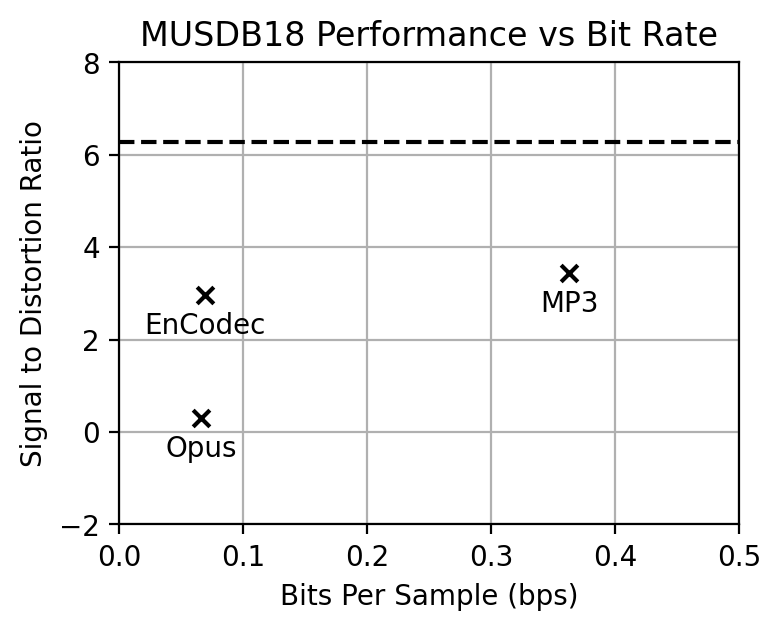

In [123]:
audio_compression_names = [
    'MP3',
    'Opus',
    'EnCodec',
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(audio_bps, mean_sdr, c='black', marker='x')
plt.annotate("No Additional Compression", (0.5, 1-baseline_sdr), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[baseline_sdr,baseline_sdr],'--',c='black')
for i, name in enumerate(audio_compression_names):
    plt.annotate(name, (audio_bps[i], mean_sdr[i]), textcoords="offset points", xytext=(0,-14), ha='center')
plt.xlabel('Bits Per Sample (bps)')
plt.ylabel('Signal to Distortion Ratio')
plt.title('MUSDB18 Performance vs Bit Rate')
plt.xlim([0,0.5])
plt.ylim([-2,8])
plt.grid(True)
plt.show()

Plot separated SDR vs visqol(original mixture, compressed mixture)